In [13]:
import pandas as pd
import os
import gzip
import pickle
import openai
import re
import copy
from tqdm import tqdm
from torch import save,load
import time
import json

In [14]:
df = pd.read_csv('outputs/outputs_chunk_1.csv')

In [15]:
print(df.iloc[3]["output"]) #example: ```json{  "categories": [     "optimistic_speculation","altcoins"

```json
{
  "categories": [ 
    "bitcoin_technology",
    "bitcoin_mining"


In [16]:

all_categories = ["optimistic_speculation", "pessimistic_speculation", "bitcoin_adoption", "bitcoin_technology", "financial_products", "bitcoin_challenges", "scams", "bitcoin_mining", "altcoins", "educational_resources", "other"]

categories = ["optimistic_speculation", "pessimistic_speculation", "bitcoin_adoption", "bitcoin_technology", "bitcoin_challenges", "altcoins", "educational_resources"]



months = {}

# for i in range(1, 14):
for (i,file) in enumerate(os.listdir('outputs/')):
    i = i+1
    # print(i)
    df = pd.read_csv('outputs/' + file)
    for row in df.iterrows():
        row = row[1]
        index = row["index"]
        date = row["date"] # 2010-01-01 21:46:38
        output = row["output"]
        jsonoutput = output.replace("```json", "")+"]}"
        parsed = json.loads(jsonoutput)

        # for each month, get the sum of instances of each category
        month = str(date)[:7]
        if month == "nan":
            print(f"nan found, index: {index} date: {date} output: {output}")
            continue
        if month not in months:
            months[month] = {category: 0 for category in categories}
        for category in categories:
            if category in parsed["categories"]:
                months[month][category] += 1



nan found, index: nan date: nan output: ```json
{
  "categories": [ 
    "other"
nan found, index: nan date: nan output: ```json
{
  "categories": [ 
    "other"


In [17]:
months

{'2010-01': {'optimistic_speculation': 0,
  'pessimistic_speculation': 0,
  'bitcoin_adoption': 0,
  'bitcoin_technology': 6,
  'bitcoin_challenges': 1,
  'altcoins': 0,
  'educational_resources': 8},
 '2010-02': {'optimistic_speculation': 0,
  'pessimistic_speculation': 0,
  'bitcoin_adoption': 0,
  'bitcoin_technology': 9,
  'bitcoin_challenges': 1,
  'altcoins': 0,
  'educational_resources': 9},
 '2010-03': {'optimistic_speculation': 0,
  'pessimistic_speculation': 0,
  'bitcoin_adoption': 1,
  'bitcoin_technology': 4,
  'bitcoin_challenges': 1,
  'altcoins': 0,
  'educational_resources': 5},
 '2010-04': {'optimistic_speculation': 0,
  'pessimistic_speculation': 0,
  'bitcoin_adoption': 0,
  'bitcoin_technology': 4,
  'bitcoin_challenges': 3,
  'altcoins': 1,
  'educational_resources': 4},
 '2010-05': {'optimistic_speculation': 0,
  'pessimistic_speculation': 0,
  'bitcoin_adoption': 1,
  'bitcoin_technology': 0,
  'bitcoin_challenges': 1,
  'altcoins': 0,
  'educational_resources':

In [18]:
df = pd.DataFrame(columns=["month"] + categories)
for month in months:
    row = {"month": month}
    for category in categories:
        row[category] = months[month][category]
    df = pd.concat([df, pd.DataFrame([row])])

df = df.sort_values(by="month")
df = df.reset_index(drop=True)

# get the number of posts for each month
posts_count = df[categories].sum(axis=1)

In [20]:
posts_count = posts_count.reset_index(drop=True)

In [22]:
df["posts_count"] = posts_count

In [24]:
df.to_csv('raw_values.csv', index=False)

In [25]:
# Obtain a categorical distribution for each month
for index, row in df.iterrows():
    total = sum(df.loc[index, category] for category in categories)
    # print(total)
    for category in categories:
        df.loc[index, category] = df.loc[index, category] / total


df.to_csv('normalized_values.csv', index=False)

In [26]:
df

,month,optimistic_speculation,pessimistic_speculation,bitcoin_adoption,bitcoin_technology,bitcoin_challenges,altcoins,educational_resources,posts_count
0,2010-01,0.0,0.0,0.0,0.4,0.066667,0.0,0.533333,15
1,2010-02,0.0,0.0,0.0,0.473684,0.052632,0.0,0.473684,19
2,2010-03,0.0,0.0,0.090909,0.363636,0.090909,0.0,0.454545,11
3,2010-04,0.0,0.0,0.0,0.333333,0.25,0.083333,0.333333,12
4,2010-05,0.0,0.0,0.25,0.0,0.25,0.0,0.5,4
...,...,...,...,...,...,...,...,...,...
166,2023-11,0.145897,0.015198,0.069909,0.197568,0.194529,0.036474,0.340426,329
167,2023-12,0.139276,0.033426,0.066852,0.192201,0.175487,0.05571,0.337047,359
168,2024-01,0.147929,0.035503,0.08284,0.186391,0.142012,0.035503,0.369822,338
169,2024-02,0.147186,0.004329,0.056277,0.177489,0.199134,0.038961,0.376623,231


In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[categories+["posts_count"]] = scaler.fit_transform(df[categories+["posts_count"]])
df.rename(columns={"month":"date"}, inplace=True)
df.to_csv('general.csv', index=False)

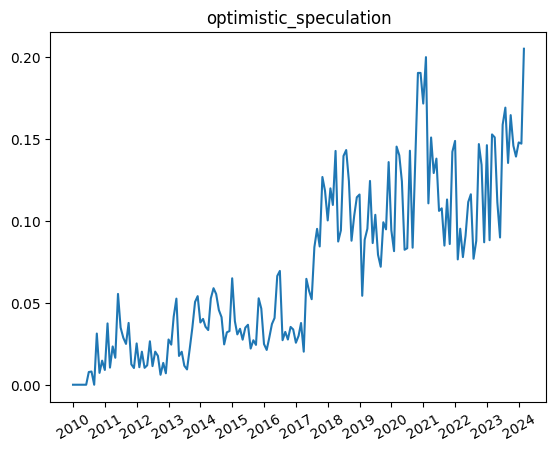

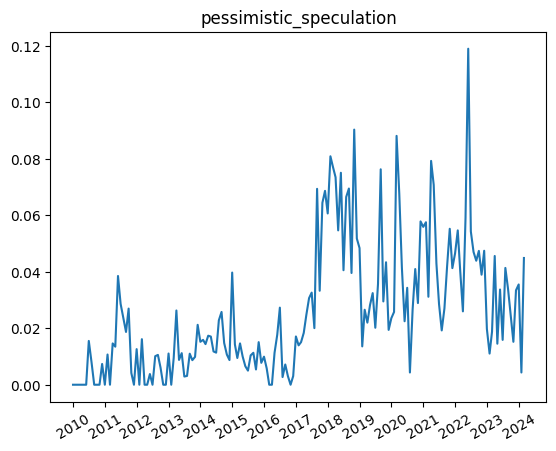

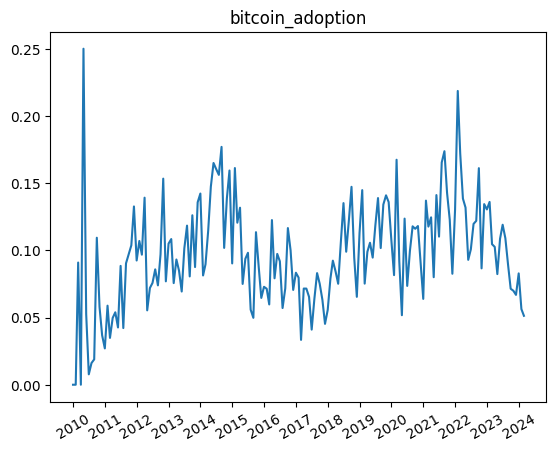

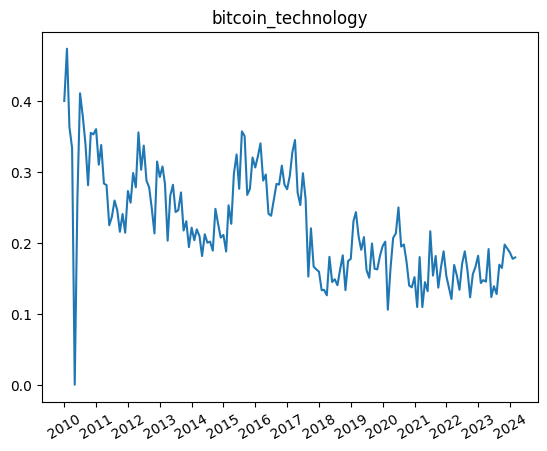

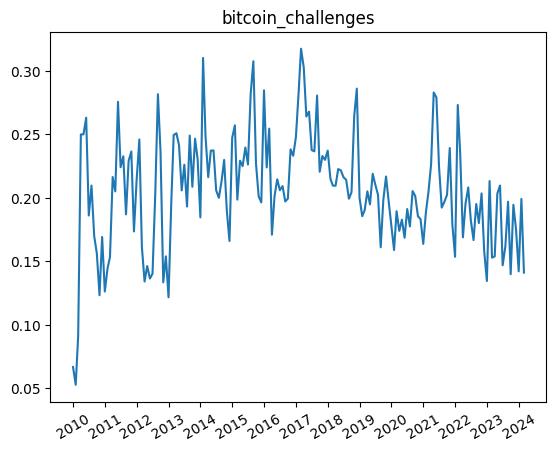

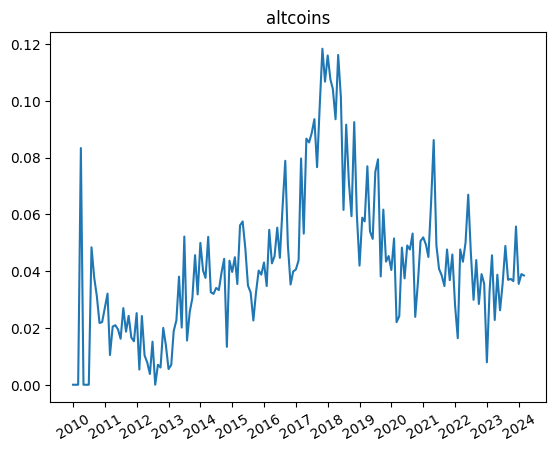

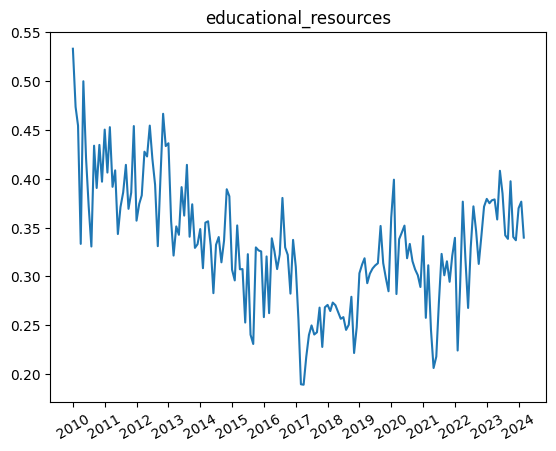

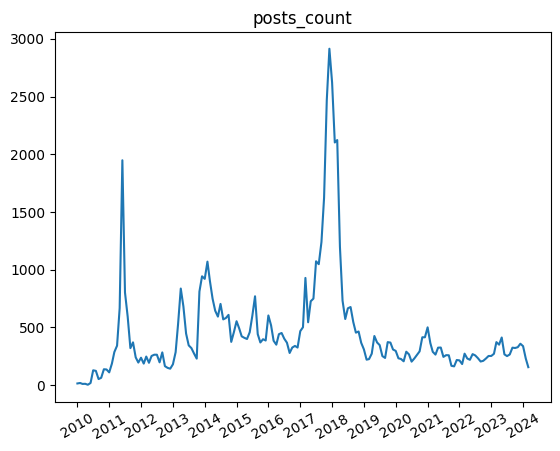

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

df = pd.read_csv('normalized_values.csv')
df["month"] = pd.to_datetime(df["month"])
df = df.set_index("month")

# make a plot for each category

for category in categories+["posts_count"]:
    fig, ax = plt.subplots()
    ax.plot(df.index, df[category])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_tick_params(rotation=30)
    ax.set_title(category)
    plt.show()